# Imports

In [1]:
# Checa ambiente - se rodando local não usa o Google Drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if (IN_COLAB):
    !pip install pytorch_lightning -qqq
    import pytorch_lightning
    !pip install neptune
    import neptune
    from google.colab import drive 
    drive.mount('/content/gdrive')

In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [4]:
# Redução das mensagens de log no terminal.
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

# Carregamento dos dados

In [5]:
if (IN_COLAB):
    root = '/content/gdrive/MyDrive/IA901A_Projeto/data/interim/OASIS_slices2_flat'
else:
    root = '../../../data/interim/OASIS_slices2_flat'

In [6]:
def setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfList = []

    if(tfGrayscale):
        tfList.append(transforms.Grayscale(num_output_channels=3))

    if(tfRdRotate):
        tfList.append(transforms.RandomRotation(10))

    if (tfHzFlip):
        tfList.append(transforms.RandomHorizontalFlip())
        
    if (tfResize):
        tfList.append(transforms.Resize(256))

    if (tfCtrCrop):
        tfList.append(transforms.CenterCrop(224))

    tfList.append(transforms.ToTensor())

    if (tfNormalize):
        tfList.append(transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225]))

    transform_lst = transforms.Compose(tfList)

    return transform_lst

In [7]:
def transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize):
    tfText = "Base"

    if(tfGrayscale):
        tfText = tfText + "+Grayscale"

    if(tfRdRotate):
        tfText = tfText + "+Random Rotation"

    if (tfHzFlip):
        tfText = tfText + "+Random Hz Flip"
        
    if (tfResize):
        tfText = tfText + "+Resize"

    if (tfCtrCrop):
        tfText = tfText + "+Center Crop"

    if (tfNormalize):
        tfText = tfText + "+Normalization"

    return tfText

In [8]:
from collections import Counter

dataset0=datasets.ImageFolder(root=root,transform=None)
print(len(dataset0))
class_names=dataset0.classes
print(class_names)
print(len(class_names))

print("Número de amostras por classe: ", dict(Counter(dataset0.targets)))

4344
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
4
Número de amostras por classe:  {0: 896, 1: 80, 2: 2528, 3: 840}


In [9]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform, batch_size):
        super().__init__()
        self.root_dir = root
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test], generator=torch.Generator().manual_seed(42))

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size, num_workers=3, shuffle=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size, num_workers=3)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset

In [10]:
# Datamodule baseados nas transformações

batch_size = 32
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

# Vizualizando imagens

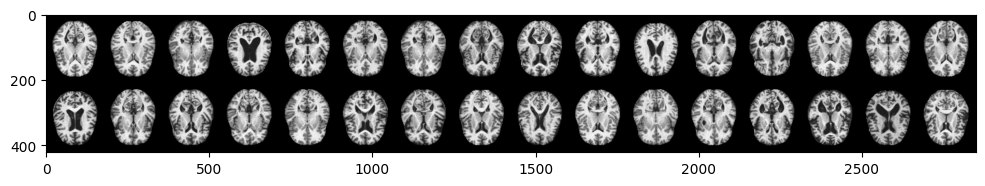

In [11]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Definindo e treinando o modelo base: AlexNet

In [12]:
print(len(class_names))

4


## Funções para definição do modelo, treinamento, testes e métricas

In [13]:
import torchmetrics
from torchmetrics import MetricCollection
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall

class MyModel(LightningModule):

    def __init__(self):
        num_classes = len(class_names)
        super().__init__()
        self.model = models.alexnet(pretrained=True)
        self.model.classifier = nn.Sequential( nn.Linear(9216,1024),
                                               nn.ReLU(),
                                               nn.Dropout(p=0.5),
                                               nn.Linear(1024, num_classes),
                                               nn.LogSoftmax(dim=1))
        # TorchMetrics
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes),
            MulticlassPrecision(num_classes),
            MulticlassRecall(num_classes)
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.val_metrics = metrics.clone(prefix='val_')
        self.test_metrics = metrics.clone(prefix='test_')

    def forward(self, x):
        x = self.model(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.train_metrics(pred, y)
        self.log_dict(output)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)

        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))

        output = self.val_metrics(pred, y)
        self.log_dict(output)
        

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        
        loss = F.cross_entropy(y_hat, y)
        pred = torch.flatten(y_hat.argmax(dim=1, keepdim=True))
        
        if (batch_idx == 0):
            self.all_labels = y.clone()
            self.all_preds = pred.clone()
        else:
            self.all_labels = torch.cat((self.all_labels, y))
            self.all_preds = torch.cat((self.all_preds, pred))
        
        output = self.test_metrics(pred, y)
        self.log_dict(output)


In [14]:
def train_model(model, epochs, datamodule):

    trainer = pl.Trainer(max_epochs=epochs)
    trainer.fit(model, datamodule)

    return trainer

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     

def plot_matrix(title, model):

    ax = plt.subplot()
    cm = confusion_matrix(model.all_labels.cpu(), model.all_preds.cpu())

    sns.set_style("darkgrid")
    sns.set(rc={"figure.figsize":(20, 4)})
    colormap = sns.color_palette("Blues",12)
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=colormap)  

    # labels, title and ticks
    ax.set_xlabel('Predições:')
    ax.set_ylabel('Labels:')
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names, rotation=0)

In [16]:
def test_model(model, datamodule, trainer, tfText):
    print("Modelo: " + tfText)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(dataloaders=test_loader)

    plot_matrix("Modelo: "+ tfText, model)

## Treinamento e Teste dos Modelos

In [17]:
batch_size = 32
epochs = 62

Epoch 61: 100%|██████████| 109/109 [00:17<00:00,  6.22it/s, v_num=196]
Modelo: Base
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 26.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │     0.793185830116272     │
│ test_MulticlassPrecision  │    0.7794430255889893     │
│   test_MulticlassRecall   │     0.793185830116272     │
└───────────────────────────┴───────────────────────────┘

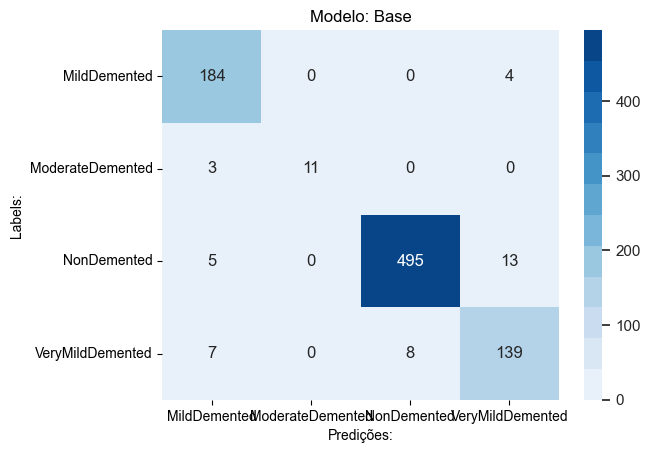

In [18]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:17<00:00,  6.24it/s, v_num=197]
Modelo: Base+Grayscale
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 25.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.6906414031982422     │
│ test_MulticlassPrecision  │    0.6749739646911621     │
│   test_MulticlassRecall   │    0.6906414031982422     │
└───────────────────────────┴───────────────────────────┘

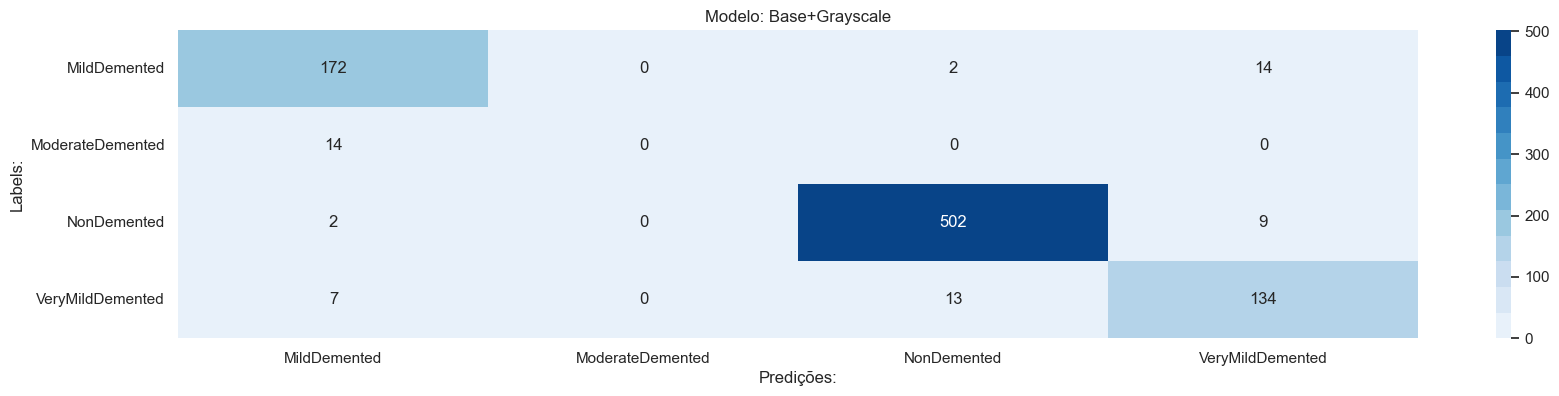

In [19]:
# Definição das transformações a serem utilizadas
tfGrayscale = True
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:26<00:00,  4.13it/s, v_num=198]
Modelo: Base+Random Rotation
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 20.50it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7904370427131653     │
│ test_MulticlassPrecision  │    0.7856619954109192     │
│   test_MulticlassRecall   │    0.7904370427131653     │
└───────────────────────────┴───────────────────────────┘

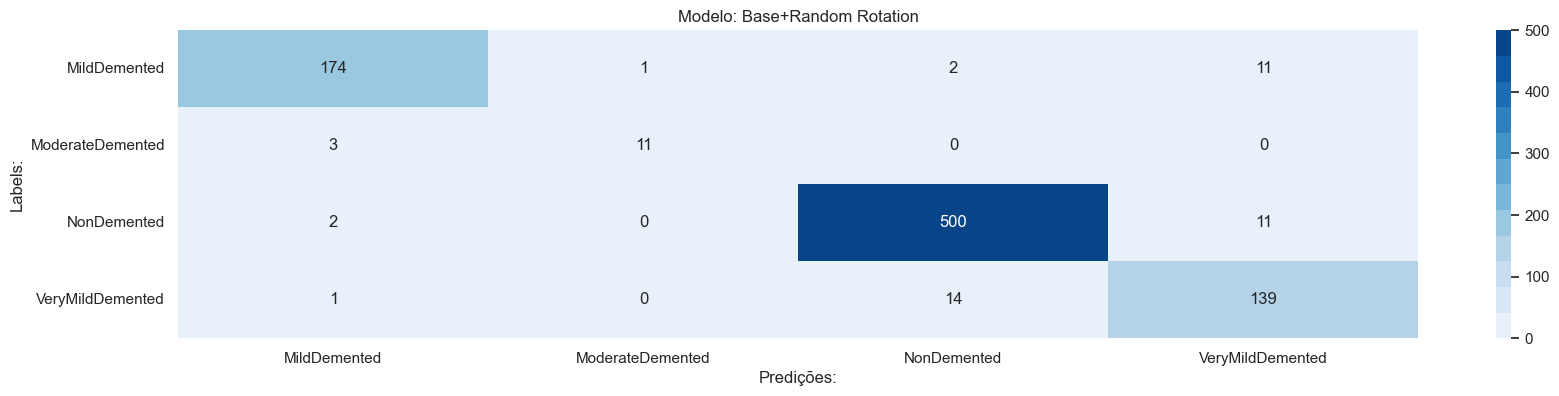

In [20]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = True
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:28<00:00,  3.77it/s, v_num=200]
Modelo: Base+Random Hz Flip
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 22.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │           0.25            │
│ test_MulticlassPrecision  │    0.14758342504501343    │
│   test_MulticlassRecall   │           0.25            │
└───────────────────────────┴───────────────────────────┘

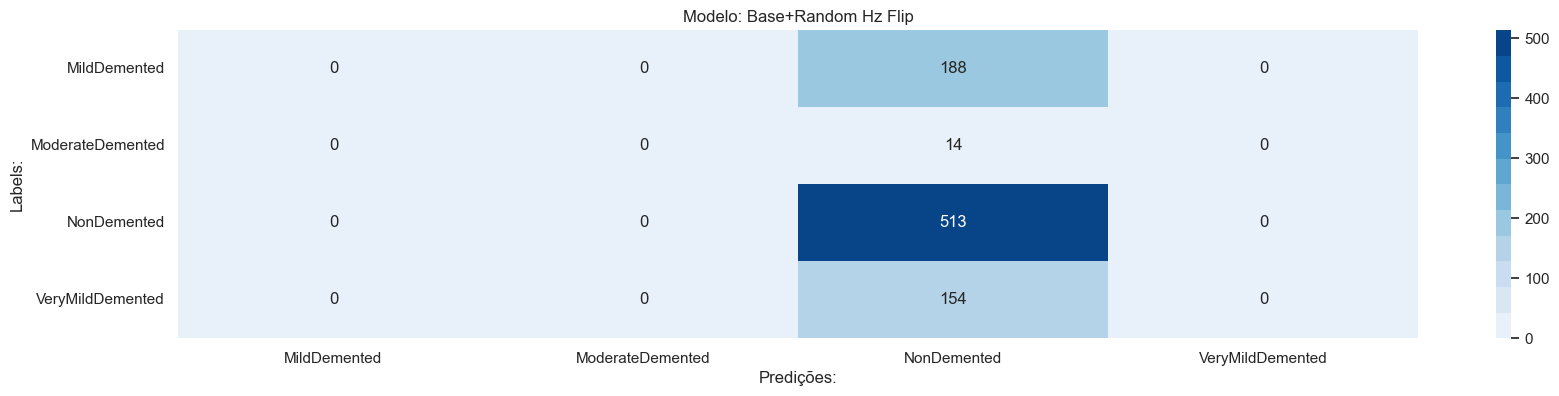

In [21]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = True
tfResize = False
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:35<00:00,  3.07it/s, v_num=202]
Modelo: Base+Resize
Testing DataLoader 0: 100%|██████████| 28/28 [00:02<00:00, 11.71it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.8204523921012878     │
│ test_MulticlassPrecision  │    0.8184898495674133     │
│   test_MulticlassRecall   │    0.8204523921012878     │
└───────────────────────────┴───────────────────────────┘

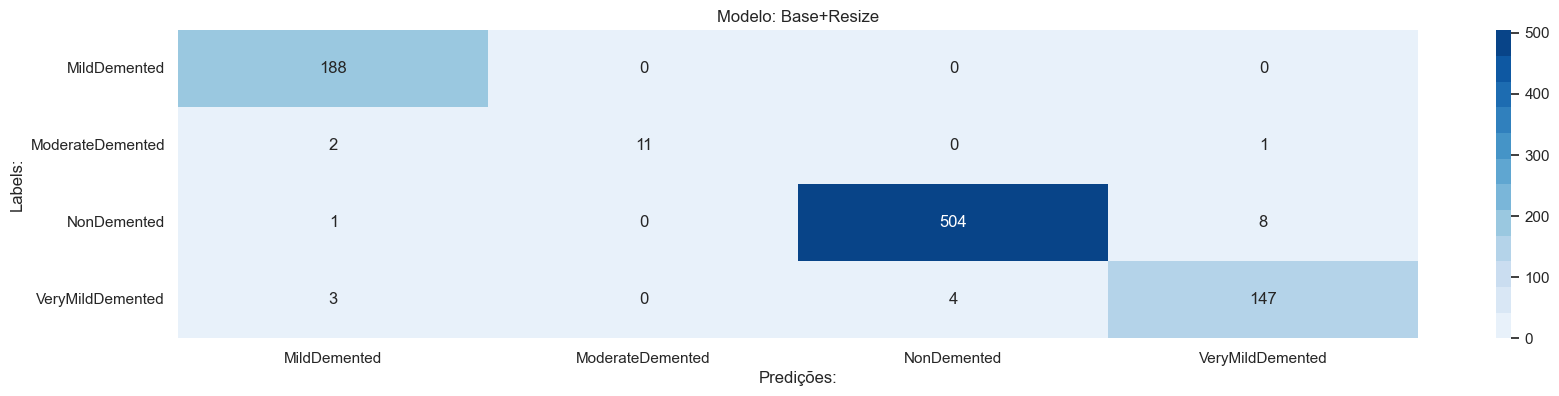

In [22]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = True
tfCtrCrop = False
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:25<00:00,  4.32it/s, v_num=204]
Modelo: Base+Center Crop
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 17.47it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.8323526978492737     │
│ test_MulticlassPrecision  │    0.8286399841308594     │
│   test_MulticlassRecall   │    0.8323526978492737     │
└───────────────────────────┴───────────────────────────┘

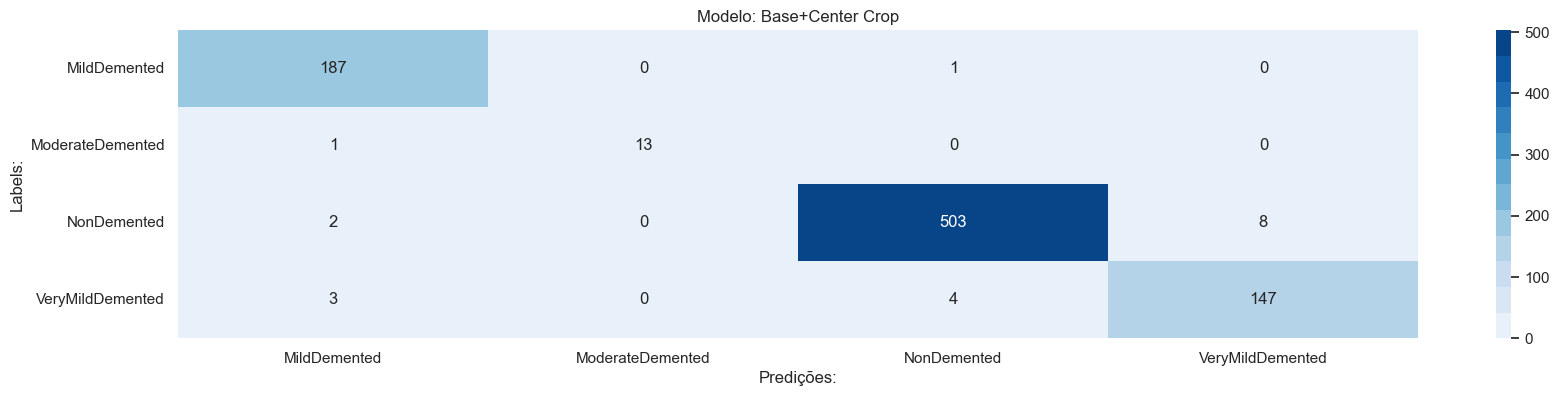

In [23]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = True
tfNormalize = False

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)

Epoch 61: 100%|██████████| 109/109 [00:25<00:00,  4.31it/s, v_num=206]
Modelo: Base+Normalization
Testing DataLoader 0: 100%|██████████| 28/28 [00:01<00:00, 20.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test_MulticlassAccuracy  │    0.7956822514533997     │
│ test_MulticlassPrecision  │    0.7875196933746338     │
│   test_MulticlassRecall   │    0.7956822514533997     │
└───────────────────────────┴───────────────────────────┘

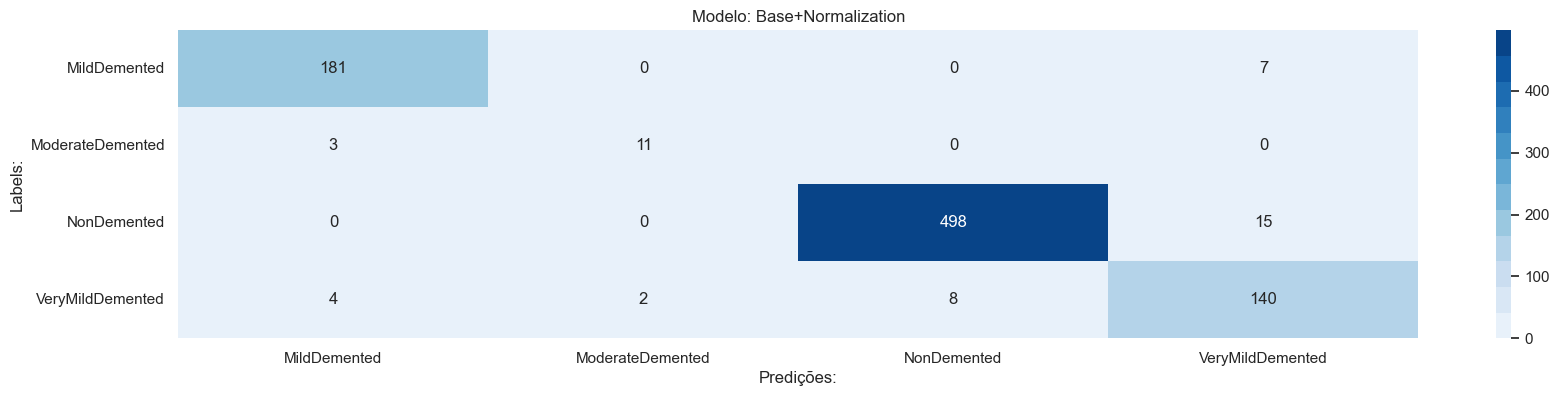

In [24]:
# Definição das transformações a serem utilizadas
tfGrayscale = False
tfRdRotate = False
tfHzFlip = False
tfResize = False
tfCtrCrop = False
tfNormalize = True

transforms_set = setup_transforms(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
tf_text = transforms_text(tfGrayscale, tfRdRotate, tfHzFlip, tfResize, tfCtrCrop, tfNormalize)
datamodule = DataModule(transforms_set, batch_size)
datamodule.setup()

model = MyModel()
tr = train_model(model, epochs, datamodule)
test_model(model, datamodule, tr, tf_text)